# BMM using scikit learn 

## Author: Jordan Melendez, Alexandra Semposki

### Date last edited: 26 February 2024

In this notebook, we attempt to use scikit learn to develop a GP with correlated data input to perform BMM. We then compare results to the exact choices made using `GPJaxEmcee`.

In [6]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_expQ_alphas_onlyc2.npz')

In [62]:
n_xeft = data_xeft["dens_scaled"]
n_pqcd = data_pqcd["dens_scaled"]
p_mean_xeft = data_xeft["mean"][:, -1]
p_stdv_xeft = data_xeft["std_dev"][:, -1]
p_cov_xeft = data_xeft["cov"][..., -1]

p_mean_pqcd = data_pqcd["mean"][:, -1]
p_stdv_pqcd = data_pqcd["std_dev"][:, -1]
p_cov_pqcd = data_pqcd["cov"][..., -1]

In [63]:
def get_closest_mask(array, values):
    """Returns a mask corresponding to the locations in array that are closest to values.
    
    array and values must be sorted
    """
    idxs = np.searchsorted(array, values, side="left")

    # find indexes where previous index is closer
    prev_idx_is_less = ((idxs == len(array))|(np.fabs(values - array[np.maximum(idxs-1, 0)]) < np.fabs(values - array[np.minimum(idxs, len(array)-1)])))
    idxs[prev_idx_is_less] -= 1
    return np.isin(np.arange(len(array)), idxs)

def get_linear_mask_in_log_space(x, x_min, x_max, log_x_step, base=10):
    lin_x = np.arange(
        np.emath.logn(n=base, x=x_min),
        np.emath.logn(n=base, x=x_max),
        log_x_step
    )
    closest = get_closest_mask(np.emath.logn(n=base, x=x), lin_x)
    return (x <= x_max) & (x >= x_min) & closest

In [64]:
mask_train_xeft = get_linear_mask_in_log_space(n_xeft, x_min=1, x_max=5, log_x_step=0.15, base=10)
n_train_xeft = n_xeft[mask_train_xeft]
p_train_xeft = p_mean_xeft[mask_train_xeft]
p_train_stdv_xeft = p_stdv_xeft[mask_train_xeft]
p_train_cov_xeft = p_cov_xeft[mask_train_xeft][:, mask_train_xeft]

mask_train_pqcd = get_linear_mask_in_log_space(n_pqcd, x_min=5, x_max=101, log_x_step=0.2, base=10)
n_train_pqcd = n_pqcd[mask_train_pqcd]
p_train_pqcd = p_mean_pqcd[mask_train_pqcd]
p_train_stdv_pqcd = p_stdv_pqcd[mask_train_pqcd]
p_train_cov_pqcd = p_cov_pqcd[mask_train_pqcd][:, mask_train_pqcd]

In [65]:
# instead of above, use the exact same points used in GPJaxEmcee implementation
training_data = np.load('../data/gpjaxemcee_data/correlated_training_data.npz')
print(training_data.files)
print(training_data['density'])

['density', 'dens_log', 'mean', 'std', 'cov']
[ 0.12988314  0.18313856  0.23639399  0.28964942  6.41402337  9.07679466
 11.73956594 14.40233723]


In [66]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

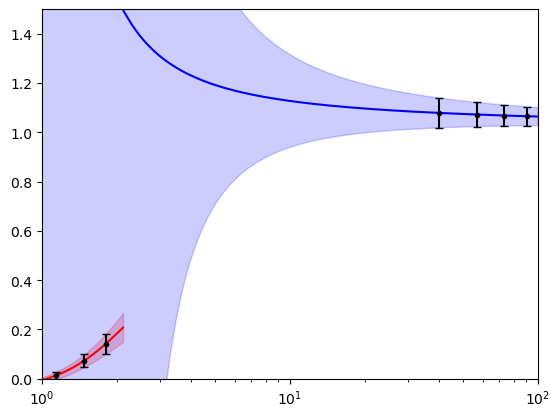

In [67]:
fig, ax = plt.subplots()
ax: Axes

color_xeft = "red"
color_pqcd = "blue"

# n0
n0 = 0.16

ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log')
ax.plot(n_xeft, p_mean_xeft, color='red')
#ax.semilogx(n_xeft, p_mean_xeft, color=color_xeft)
ax.fill_between(n_xeft, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
#ax.errorbar(x=n_train_xeft, y=p_train_xeft, yerr=p_train_stdv_xeft, **errorbar_kwargs)
ax.errorbar(x=training_data['density']/n0, y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
#ax.semilogx(n_pqcd, p_mean_pqcd, color=color_pqcd)
ax.plot(n_pqcd, p_mean_pqcd, color='blue')
ax.fill_between(n_pqcd, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
#ax.errorbar(x=n_train_pqcd, y=p_train_pqcd, yerr=p_train_stdv_pqcd, **errorbar_kwargs)

In [68]:
# X_train_xeft = np.log10(n_train_xeft)[:, None]
# X_train_pqcd = np.log10(n_train_pqcd)[:, None]

# noise_off_diag = np.zeros((p_train_cov_xeft.shape[0], p_train_cov_pqcd.shape[1]))
# noise = np.block([
#     [p_train_cov_xeft, noise_off_diag],
#     [noise_off_diag.T, p_train_cov_pqcd]
# ])
# noise

In [69]:
# kernel = C(constant_value=10, constant_value_bounds="fixed") * RBF()
kernel = C() * RBF()

# X_train = np.log10(np.concatenate((n_train_xeft, n_train_pqcd))[:, None])
# y_train = np.concatenate((p_train_xeft, p_train_pqcd))
X_train = training_data['dens_log'].reshape(-1,1)  # training in the log scale
y_train = training_data['mean'].reshape(-1,1)

gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov']
)
# gp = GaussianProcessRegressor(
#     kernel=kernel,
#     alpha=np.diag(noise)
# )

gp.fit(X_train, y_train)

GaussianProcessRegressor2dNoise(alpha=array([[5.10952568e-05, 9.88348090e-05, 1.43970483e-04, 1.76200551e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.88348090e-05, 2.22780381e-04, 3.68834235e-04, 5.07446380e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.43970483e-04, 3.68834235e-04, 6.78113458e-04, 1.02283543e-03,...
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.97074015e-03, 2.41402247e-03, 2.09441617e-03, 1.88227765e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.57615872e-03, 2.09441617e-03, 1.81776790e-03, 1.63410638e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.31433782e-03, 1.88227765e-03, 1.63410638e-03, 1.46932715e-03]]),
                                kernel=1**2 * RBF(length_scale=1))

In [70]:
gp.kernel_

0.582**2 * RBF(length_scale=1.93)

In [71]:
# n_pred = np.logspace(0, 2, 100, base=10)
# X = np.log10(n_pred)[:, None]
# pull same values as in GPJaxEmcee (need to copy code here for now...sad face)
dens_test = np.linspace(0.05, 16.0, 600)[::2]
X = np.log(dens_test).reshape(-1,1)
y_pred, y_stdv = gp.predict(X, return_std=True)

Text(0, 0.5, '$P(n)/P_{FG}(n)$')

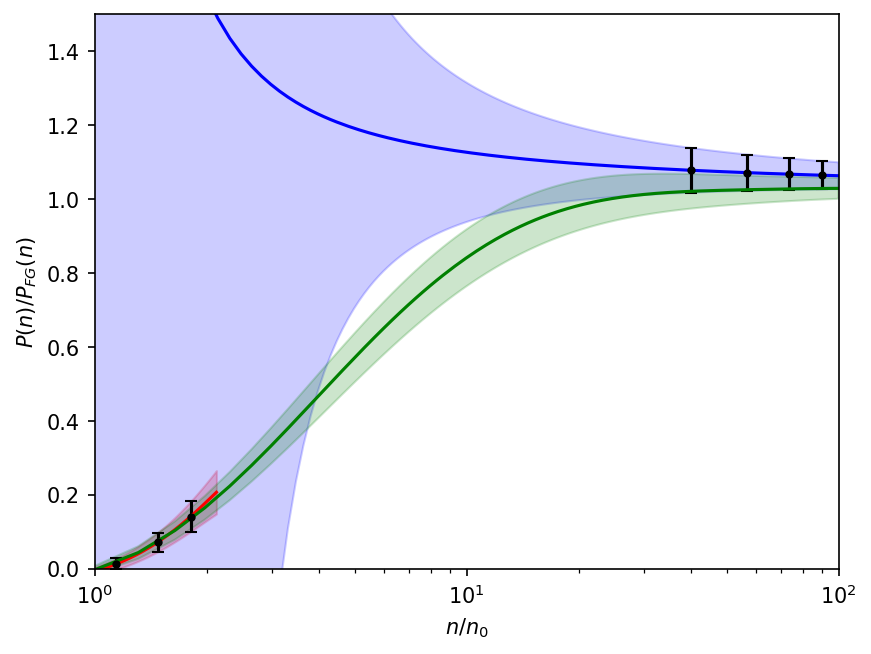

In [72]:
fig, ax = plt.subplots(dpi=150)

ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log')
ax.plot(n_xeft, p_mean_xeft, color='red')
#ax.semilogx(n_xeft, p_mean_xeft, color=color_xeft)
ax.fill_between(n_xeft, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
#ax.errorbar(x=n_train_xeft, y=p_train_xeft, yerr=p_train_stdv_xeft, **errorbar_kwargs)
ax.errorbar(x=training_data['density']/n0, y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
#ax.semilogx(n_pqcd, p_mean_pqcd, color=color_pqcd)
ax.plot(n_pqcd, p_mean_pqcd, color='blue')
ax.fill_between(n_pqcd, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
#ax.errorbar(x=n_train_pqcd, y=p_train_pqcd, yerr=p_train_stdv_pqcd, **errorbar_kwargs)

ax.plot(dens_test/n0, y_pred, c="g")
ax.fill_between(dens_test/n0, y_pred-y_stdv, y_pred+y_stdv, color="g", alpha=0.2)

ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')